In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'brain-stroke-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2387714%2F4029610%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240428%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240428T100155Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D631362598210a2c7cf50c5bb6e87d9663a93718bd3a8d7017f20e862c5f77e4b1f9e263a481f8740963fd9f31e5570ff9b0751c7dc27a126e2fe3f8d137335654afee428a4a1f8d07b24ffae985874330d22c23ee55e8c4d64cb42a59189718907dd4175269aaf6125b11e150a1b6fb33aab164b7aadf52bdfb03f5400f9818fcc2bc5cdce6d154272a35d441b273968243d2b34c394737c926b03d7a11b008418679201ae493214af133809ea7476052aa52241d9272e4e34931a0d5e2fdefadbe681b4f5868d54b13db444ba24ffc5ff6ecf88a8831d92005f68e09f2f126decd44072321987a2065c1df86c80f0d85b593ea5913a0ccf7734c69041d44e97'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 48311 bytes downloaded
Downloaded and uncompressed: brain-stroke-dataset
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
import pandas as pd
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-stroke-dataset/brain_stroke.csv


In [3]:
!pip install dash dash-bootstrap-components pandas plotly seaborn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.5/222.5 kB 3.2 MB/s eta 0:00:00


In [4]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Load data
data = pd.read_csv('../input/brain-stroke-dataset/brain_stroke.csv')

# Create Dash app
app = dash.Dash(__name__, external_stylesheets=['https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css'])

# Create bar plot function
def create_bar_plot(variable):
    varValue = data[variable].value_counts()
    fig = px.bar(varValue, x=varValue.index, y=varValue, title=f'{variable} Frequency')
    return fig

# Create histogram function
def create_histogram(variable):
    fig = px.histogram(data, x=variable, nbins=70, title=f'{variable} Distribution')
    return fig

# Create dashboard layout
app.layout = html.Div([
    html.H1("Brain Stroke Dashboard"),
    dcc.Dropdown(
        id='category-dropdown',
        options=[
            {'label': 'Gender', 'value': 'gender'},
            {'label': 'Hypertension', 'value': 'hypertension'},
            {'label': 'Heart Disease', 'value': 'heart_disease'},
            {'label': 'Ever Married', 'value': 'ever_married'},
            {'label': 'Work Type', 'value': 'work_type'},
            {'label': 'Residence Type', 'value': 'Residence_type'},
            {'label': 'Smoking Status', 'value': 'smoking_status'},
        ],
        value='gender',
        clearable=False
    ),
    dcc.Graph(id='bar-plot'),

    dcc.Dropdown(
        id='numeric-dropdown',
        options=[
            {'label': 'Average Glucose Level', 'value': 'avg_glucose_level'},
            {'label': 'BMI', 'value': 'bmi'},
            {'label': 'Age', 'value': 'age'},
        ],
        value='age',
        clearable=False
    ),
    dcc.Graph(id='histogram-plot'),
])

# Callback to update bar plot based on selected category
@app.callback(
    Output('bar-plot', 'figure'),
    [Input('category-dropdown', 'value')]
)
def update_bar_plot(selected_variable):
    return create_bar_plot(selected_variable)

# Callback to update histogram based on selected numeric value
@app.callback(
    Output('histogram-plot', 'figure'),
    [Input('numeric-dropdown', 'value')]
)
def update_histogram(selected_variable):
    return create_histogram(selected_variable)

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

In [5]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Load data
data = pd.read_csv('../input/brain-stroke-dataset/brain_stroke.csv')

# Create Dash app
app = dash.Dash(__name__, external_stylesheets=['https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css'])

# Create bar plot function
def create_bar_plot(variable):
    varValue = data[variable].value_counts()
    fig = px.bar(varValue, x=varValue.index, y=varValue, title=f'{variable} Frequency')
    return fig

# Create histogram function
def create_histogram(variable):
    fig = px.histogram(data, x=variable, nbins=70, title=f'{variable} Distribution')
    return fig

# Create violin plot function
def create_violin_plot(variable, category):
    fig = px.violin(data, y=variable, x=category, title=f'{variable} by {category}', box=True, points='all')
    return fig

# Create dashboard layout
app.layout = html.Div([
    html.H1("Brain Stroke Dashboard"),
    dcc.Dropdown(
        id='category-dropdown',
        options=[
            {'label': 'Gender', 'value': 'gender'},
            {'label': 'Hypertension', 'value': 'hypertension'},
            {'label': 'Heart Disease', 'value': 'heart_disease'},
            {'label': 'Ever Married', 'value': 'ever_married'},
            {'label': 'Work Type', 'value': 'work_type'},
            {'label': 'Residence Type', 'value': 'Residence_type'},
            {'label': 'Smoking Status', 'value': 'smoking_status'},
        ],
        value='gender',
        clearable=False
    ),
    dcc.Graph(id='bar-plot'),

    dcc.Dropdown(
        id='numeric-dropdown',
        options=[
            {'label': 'Average Glucose Level', 'value': 'avg_glucose_level'},
            {'label': 'BMI', 'value': 'bmi'},
            {'label': 'Age', 'value': 'age'},
        ],
        value='age',
        clearable=False
    ),
    dcc.Graph(id='histogram-plot'),

    dcc.Dropdown(
        id='violin-dropdown',
        options=[
            {'label': 'Gender', 'value': 'gender'},
            {'label': 'Hypertension', 'value': 'hypertension'},
            {'label': 'Heart Disease', 'value': 'heart_disease'},
            {'label': 'Ever Married', 'value': 'ever_married'},
            {'label': 'Work Type', 'value': 'work_type'},
            {'label': 'Residence Type', 'value': 'Residence_type'},
            {'label': 'Smoking Status', 'value': 'smoking_status'},
        ],
        value='gender',
        clearable=False
    ),
    dcc.Dropdown(
        id='violin-numeric-dropdown',
        options=[
            {'label': 'Age', 'value': 'age'},
            {'label': 'BMI', 'value': 'bmi'},
            {'label': 'Average Glucose Level', 'value': 'avg_glucose_level'},
        ],
        value='age',
        clearable=False
    ),
    dcc.Graph(id='violin-plot'),
])

# Callback to update bar plot based on selected category
@app.callback(
    Output('bar-plot', 'figure'),
    [Input('category-dropdown', 'value')]
)
def update_bar_plot(selected_variable):
    return create_bar_plot(selected_variable)

# Callback to update histogram based on selected numeric value
@app.callback(
    Output('histogram-plot', 'figure'),
    [Input('numeric-dropdown', 'value')]
)
def update_histogram(selected_variable):
    return create_histogram(selected_variable)

# Callback to update violin plot based on selected category and numeric value
@app.callback(
    Output('violin-plot', 'figure'),
    [Input('violin-dropdown', 'value'), Input('violin-numeric-dropdown', 'value')]
)
def update_violin_plot(selected_category, selected_variable):
    return create_violin_plot(selected_variable, selected_category)

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

In [ ]:
import dash
from dash import dcc, html, Input, Output
import plotly.express as px
import pandas as pd

# Load the CSV files
df_testing = pd.read_csv("HIV_ANC_Testing_2023.csv")
df_children = pd.read_csv("HIV_Children_2023.csv")
df_infant = pd.read_csv("HIV_Early_Infant_Diagnosis_2023.csv")
df_paediatric = pd.read_csv("HIV_Paediatric_2023.csv")
df_pmtct = pd.read_csv("HIV_PMTCT_2023.csv")

# Create Dash app
app = dash.Dash(__name__, external_stylesheets=['https://stackpath.bootstrapcdn.com/bootstrap/4.5.2/css/bootstrap.min.css'])

# Define the layout
app.layout = html.Div([
    html.H1("HIV Data Dashboard"),

    # Dropdown for selecting choropleth visualization
    dcc.Dropdown(
        id='choropleth-dropdown',
        options=[
            {'label': 'ANC HIV Testing', 'value': 'ANC_TESTING'},
            {'label': 'Early Infant Diagnosis', 'value': 'INFANT_DIAGNOSIS'},
        ],
        value='ANC_TESTING',
        clearable=False
    ),
    dcc.Graph(id='choropleth-plot'),

    # Dropdown for selecting line plot
    dcc.Dropdown(
        id='line-plot-dropdown',
        options=[
            {'label': 'Paediatric ART in Afghanistan', 'value': 'PAEDIATRIC_ART'},
            {'label': 'PMTCT in Afghanistan', 'value': 'PMTCT'},
            {'label': 'Global HIV Incidence for Children (0-14)', 'value': 'GLOBAL_INCIDENCE'},
        ],
        value='PAEDIATRIC_ART',
        clearable=False
    ),
    dcc.Graph(id='line-plot'),
])

# Callback to update choropleth plot
@app.callback(
    Output('choropleth-plot', 'figure'),
    [Input('choropleth-dropdown', 'value')]
)
def update_choropleth_plot(selected_value):
    if selected_value == 'ANC_TESTING':
        df_ = df_testing[df_testing['Indicator'] == 'Number of pregnant women presenting at ANC who were tested for HIV or already knew their HIV positive status']
        df_ = df_[df_['Year'] == 2022]
    elif selected_value == 'INFANT_DIAGNOSIS':
        df_ = df_infant[df_infant['Indicator'] == 'Reported number of infants born to pregnant women living with HIV who received a virological test for HIV within 2 months of birth']
        df_ = df_[df_['Year'] == 2022]

    fig = px.choropleth(df_, locations='ISO3', color='Value', title='Choropleth Plot')
    return fig

# Callback to update line plot
@app.callback(
    Output('line-plot', 'figure'),
    [Input('line-plot-dropdown', 'value')]
)
def update_line_plot(selected_value):
    if selected_value == 'PAEDIATRIC_ART':
        df_ = df_paediatric[df_paediatric['Country/Region'] == 'Afghanistan']
        df_ = df_[df_['Indicator'] == 'Per cent of children living with HIV receiving ART']
    elif selected_value == 'PMTCT':
        df_ = df_pmtct[df_pmtct['Country/Region'] == 'Afghanistan']
        df_ = df_[df_['Indicator'] == 'Per cent of pregnant women living with HIV receiving effective ARVs for PMTCT (excludes single-dose nevirapine)']
    elif selected_value == 'GLOBAL_INCIDENCE':
        df_ = df_children[df_children['Country/Region'] == 'Global']
        df_ = df_[df_['Indicator'] == 'Estimated incidence rate (new HIV infection per 1,000 uninfected population)']
        df_ = df_[df_['Sex'] == 'Both' and df_['Age'] == 'Age 0-14']

    fig = px.line(df_, x='Year', y=['Value', 'Lower', 'Upper'], title='Line Plot')
    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


<IPython.core.display.Javascript object>

# Load And Check Data


In [ ]:
data = pd.read_csv('../input/brain-stroke-dataset/brain_stroke.csv')
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [ ]:
data.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [ ]:
data

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,1,0,1,0,0,0,1,0,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,41.0,0,0,70.15,29.8,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0
4977,40.0,0,0,191.15,31.1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1
4978,45.0,1,0,95.02,31.8,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1
4979,40.0,0,0,83.94,30.0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1


In [ ]:
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


# Variable Description
1.  gender               :  gender of the person
2.  age                  :  person's age
3.  hypertension         :  has hypertension(1) no hypertension(0)
4.  hearth_disease       :  has hearth disease(1) no hearthdisease(0)
5.  ever_married         :  has she/he ever been married Yes(1) No(0)
6.  work_type            :  work type
7.  Residence_type       :  residence type
8.  avg_glucose_level    :  average glucose level
9.  bmi                  :  body mass index
10. smoking_status       :  how often does she/he smoke
11. stroke               :  Yes(1) No(0)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


# Variable Analysis
* Categorical Variable: gender, hypertension, hearth_disease, ever_married, work_type, Residence_type,  smoking_status, stroke
* Numerical Variable: age, avg_glucose_level, bmi

## Categorical Variable

In [ ]:
data

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,1,0,1,0,0,0,1,0,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,41.0,0,0,70.15,29.8,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0
4977,40.0,0,0,191.15,31.1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,1
4978,45.0,1,0,95.02,31.8,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1
4979,40.0,0,0,83.94,30.0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1


In [ ]:
def bar_plot(variable):
    var = data[variable]
    varValue = var.value_counts()

    plt.figure(figsize = (9, 5))
    plt.bar(varValue.index, varValue)
    plt.xticks(varValue.index, varValue.index.values)
    plt.ylabel("frequancy")
    plt.title(variable)
    plt.show()
    print("{}: \n {}".format(variable,varValue))

In [ ]:
def interactive_bar_plot(variable):
    # Get the data for the specified variable
    var = data[variable]
    # Calculate the frequency of each unique value
    varValue = var.value_counts().reset_index()
    # Rename columns for clarity
    varValue.columns = [variable, 'Frequency']

    # Create an interactive bar plot using plotly.express
    fig = px.bar(varValue, x=variable, y='Frequency', title=f'Frequency of {variable}', labels={'Frequency': 'Count'})

    # Show the interactive plot
    fig.show()

    # Print the frequency data
    print(f"{variable}: \n{varValue}")

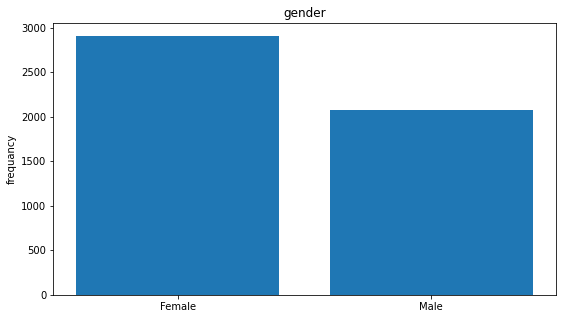

gender: 
 Female    2907
Male      2074
Name: gender, dtype: int64


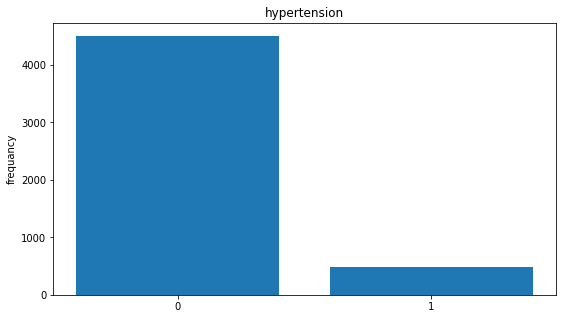

hypertension: 
 0    4502
1     479
Name: hypertension, dtype: int64


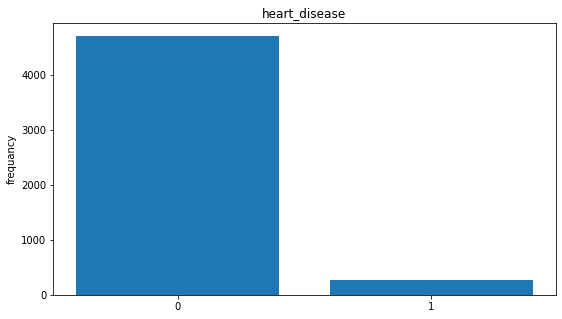

heart_disease: 
 0    4706
1     275
Name: heart_disease, dtype: int64


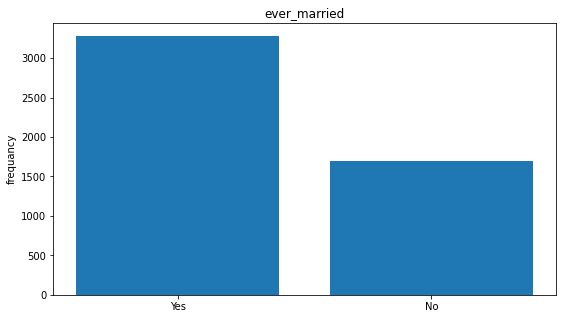

ever_married: 
 Yes    3280
No     1701
Name: ever_married, dtype: int64


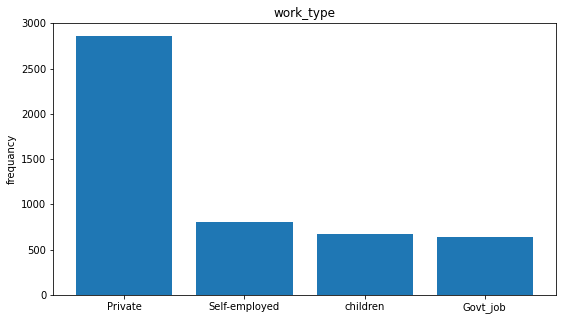

work_type: 
 Private          2860
Self-employed     804
children          673
Govt_job          644
Name: work_type, dtype: int64


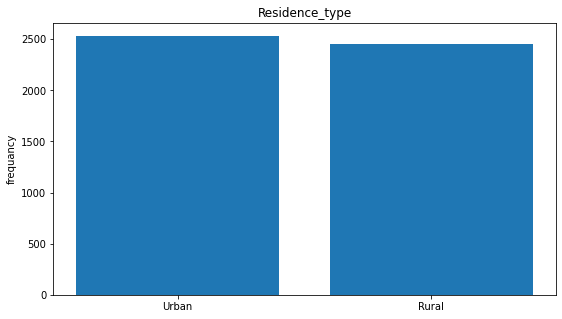

Residence_type: 
 Urban    2532
Rural    2449
Name: Residence_type, dtype: int64


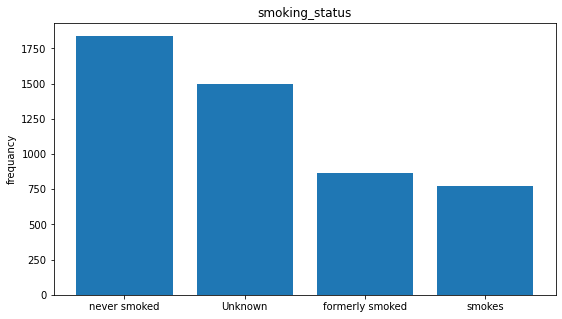

smoking_status: 
 never smoked       1838
Unknown            1500
formerly smoked     867
smokes              776
Name: smoking_status, dtype: int64


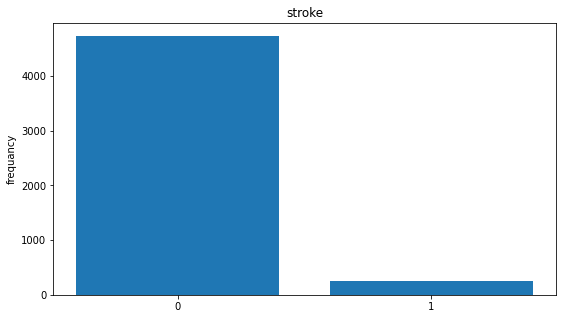

stroke: 
 0    4733
1     248
Name: stroke, dtype: int64


In [ ]:
category1 = ["gender","hypertension","heart_disease","ever_married","work_type",
              "Residence_type","smoking_status","stroke"]
for i in category1:
    bar_plot(i)

In [ ]:


category1 = ["gender","hypertension","heart_disease","ever_married","work_type",
              "Residence_type","smoking_status","stroke"]
for i in category1:
    interactive_bar_plot(i)

gender: 
   gender  Frequency
0  Female       2907
1    Male       2074


hypertension: 
   hypertension  Frequency
0             0       4502
1             1        479


heart_disease: 
   heart_disease  Frequency
0              0       4706
1              1        275


ever_married: 
  ever_married  Frequency
0          Yes       3280
1           No       1701


work_type: 
       work_type  Frequency
0        Private       2860
1  Self-employed        804
2       children        673
3       Govt_job        644


Residence_type: 
  Residence_type  Frequency
0          Urban       2532
1          Rural       2449


smoking_status: 
    smoking_status  Frequency
0     never smoked       1838
1          Unknown       1500
2  formerly smoked        867
3           smokes        776


stroke: 
   stroke  Frequency
0       0       4733
1       1        248


## Numerical Variable

In [ ]:
def his_plot(variable):
    plt.figure(figsize = (9,5))
    plt.hist(data[variable], bins =70)
    plt.xlabel(variable)
    plt.ylabel("Frequancy")
    plt.title(variable)
    plt.show()

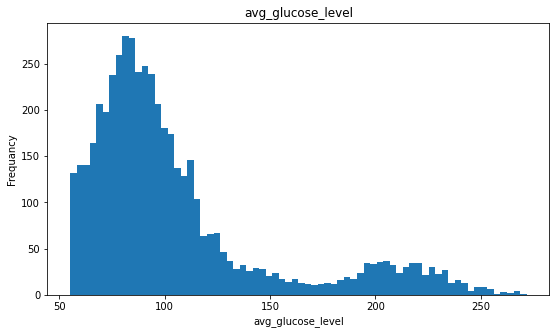

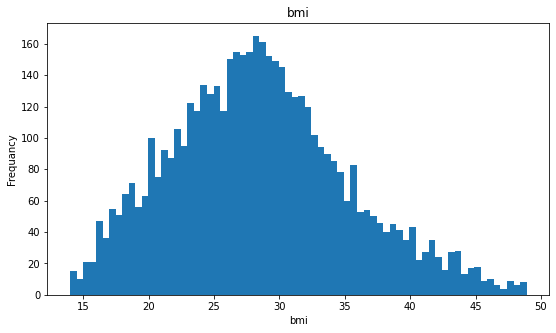

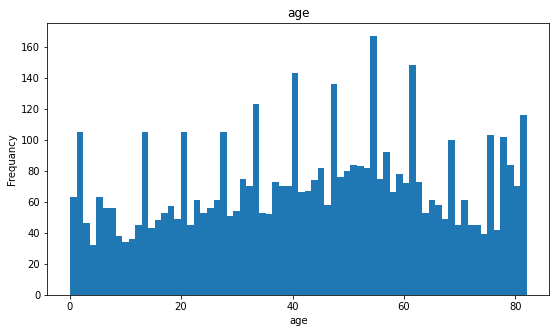

In [ ]:
category2 = ["avg_glucose_level","bmi","age"]
for c in category2:
    his_plot(c)

## Basic Data Analysis

In [ ]:
def interactive_hist_plot(variable, bins=70):
    # Create an interactive histogram using plotly.express
    fig = px.histogram(data, x=variable, nbins=bins, title=f"Histogram of {variable}", labels={"count": "Frequency"})

    # Show the interactive plot
    fig.show()

category2 = ["avg_glucose_level","bmi","age"]
for c in category2:
    interactive_hist_plot(c)

In [ ]:
data[["gender","stroke"]].groupby(["gender"], as_index = False).mean().sort_values(by = "stroke", ascending = False)

,gender,stroke
1,Male,0.052073
0,Female,0.048160


In [ ]:
data[["hypertension","stroke"]].groupby(["hypertension"], as_index = False).mean().sort_values(by = "stroke", ascending = False)

,hypertension,stroke
1,1,0.137787
0,0,0.040426


In [ ]:
data[["heart_disease","stroke"]].groupby(["heart_disease"], as_index = False).mean().sort_values(by = "stroke", ascending = False)

,heart_disease,stroke
1,1,0.170909
0,0,0.042711


In [ ]:
data[["ever_married","stroke"]].groupby(["ever_married"], as_index = False).mean().sort_values(by = "stroke", ascending = False)

,ever_married,stroke
1,Yes,0.066768
0,No,0.017049


In [ ]:
data[["work_type","stroke"]].groupby(["work_type"], as_index = False).mean().sort_values(by = "stroke", ascending = False)

,work_type,stroke
2,Self-employed,0.080846
1,Private,0.051748
0,Govt_job,0.051242
3,children,0.002972


In [ ]:
data[["Residence_type","stroke"]].groupby(["Residence_type"], as_index = False).mean().sort_values(by = "stroke", ascending = False)

,Residence_type,stroke
1,Urban,0.053318
0,Rural,0.046141


In [ ]:
data[["smoking_status","stroke"]].groupby(["smoking_status"], as_index = False).mean().sort_values(by = "stroke", ascending = False)

,smoking_status,stroke
1,formerly smoked,0.080738
3,smokes,0.054124
2,never smoked,0.048422
0,Unknown,0.031333


## Outlier Detection

In [ ]:
def detect_outliers(df,features):
    outlier_indices = []

    for i in features:
        Q1 = np.percentile(df[i],25)
        Q3 = np.percentile(df[i],75)
        IQR = Q3 - Q1
        outlier_step = IQR * 1.5
        outlier_detect = df[(df[i] < Q1 - outlier_step) | (df[i] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_detect)

    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(i for i, v in outlier_indices.items() if v > 2)

    return multiple_outliers

In [ ]:
data.loc[detect_outliers(data,["avg_glucose_level","bmi","age"])]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


In [ ]:
'''
data = data.drop(detect_outliers(data, ["avg_glucose_level","bmi","age"]), axis = 0).reset_index(drop = True)
'''

'\ndata = data.drop(detect_outliers(data, ["avg_glucose_level","bmi","age"]), axis = 0).reset_index(drop = True)                                       \n'

## Missing Value(There is no missing value)

In [ ]:
data.columns[data.isnull().any()]


Index([], dtype='object')

In [ ]:
data.isnull().sum()

gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

# Visualization

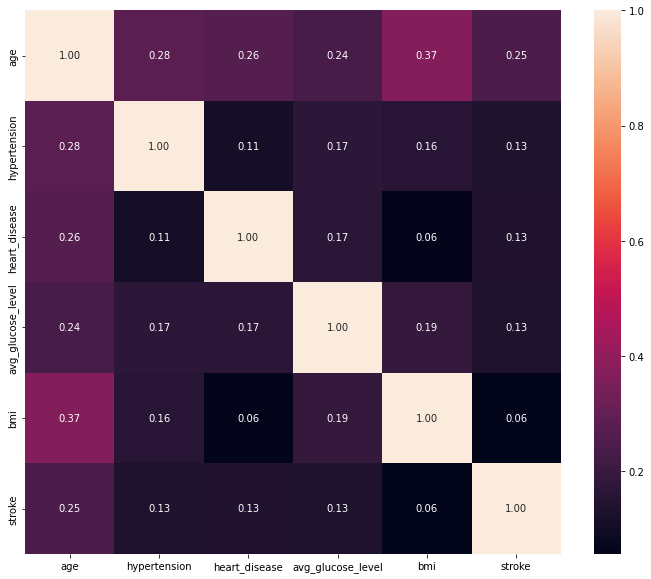

In [ ]:
plt.figure(figsize=(12,10))
sns.heatmap(data.corr(), annot=True, fmt= ".2f")
plt.show()

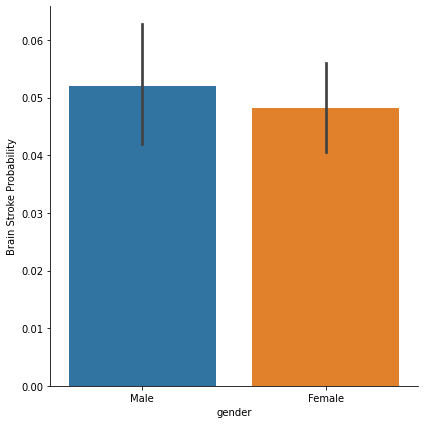

In [ ]:
a = sns.factorplot(x = "gender", y = "stroke", data = data, kind = "bar", size = 6)
a.set_ylabels("Brain Stroke Probability")

In [ ]:
# def interactive_factorplot(x, y, data):
#     # Group data by x (gender) and calculate mean of y (stroke)
#     grouped_data = data.groupby(x).mean().reset_index()

#     # Create an interactive bar plot
#     fig = px.bar(grouped_data, x=x, y=y, title=f'{y} by {x}', labels={y: 'Brain Stroke Probability'})

#     # Display the interactive plot
#     fig.show()
def interactive_factorplot(x, y, data):
    # Group data by x (gender) and calculate mean of y (stroke)
    grouped_data = data.groupby(x).mean().reset_index()

    # Create an interactive bar plot with color differentiation
    fig = px.bar(grouped_data, x=x, y=y, color=x, title=f'{y} by {x}', labels={y: 'Brain Stroke Probability'})

    # Display the interactive plot
    fig.show()
interactive_factorplot("gender", "stroke", data)

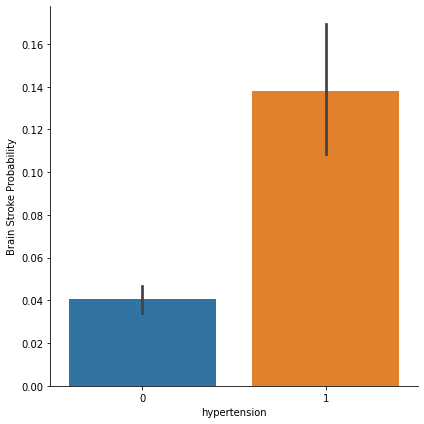

In [ ]:
a = sns.factorplot(x = "hypertension", y = "stroke", data = data, kind = "bar", size = 6)
a.set_ylabels("Brain Stroke Probability")

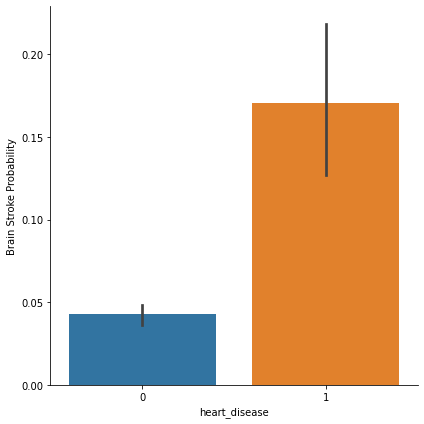

In [ ]:
a = sns.factorplot(x = "heart_disease", y = "stroke", data = data, kind = "bar", size = 6)
a.set_ylabels("Brain Stroke Probability")

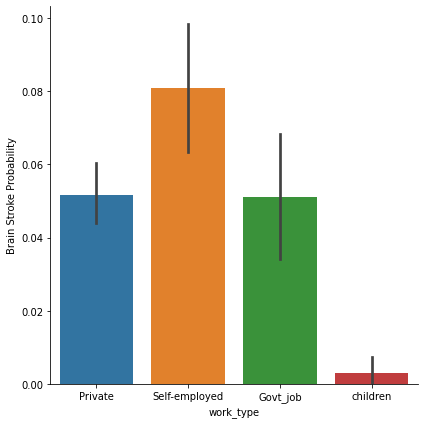

In [ ]:
a = sns.factorplot(x = "work_type", y = "stroke", data = data, kind = "bar", size = 6)
a.set_ylabels("Brain Stroke Probability")

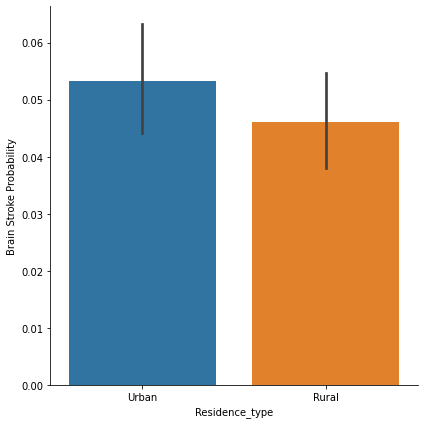

In [ ]:
a = sns.factorplot(x = "Residence_type", y = "stroke", data = data, kind = "bar", size = 6)
a.set_ylabels("Brain Stroke Probability")

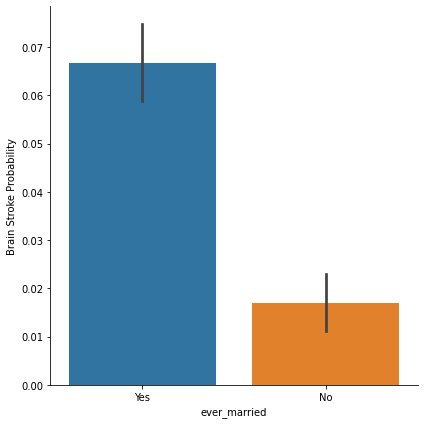

In [ ]:
a = sns.factorplot(x = "ever_married", y = "stroke", data = data, kind = "bar", size = 6)
a.set_ylabels("Brain Stroke Probability")

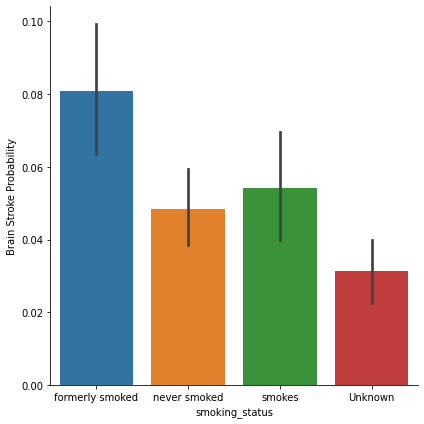

In [ ]:
a = sns.factorplot(x = "smoking_status", y = "stroke", data = data, kind = "bar", size = 6)
a.set_ylabels("Brain Stroke Probability")

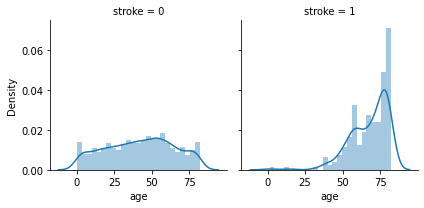

In [ ]:
a = sns.FacetGrid(data , col = "stroke")
a.map(sns.distplot, "age", bins = 25)
plt.show()

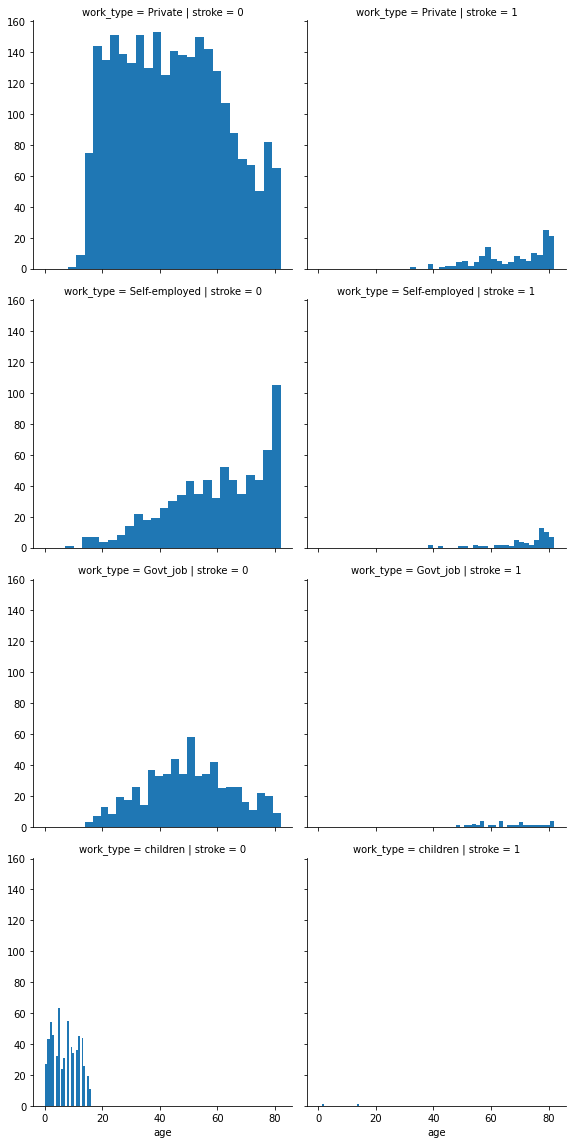

In [ ]:
g = sns.FacetGrid(data, col = "stroke", row = "work_type", size = 4)
g.map(plt.hist, "age", bins = 25)
g.add_legend()
plt.show()

# Feature Engineering

In [ ]:
data.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1


In [ ]:
data["gender"] = data["gender"].astype("category")
data = pd.get_dummies(data, columns=["gender"])
data.head()

,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,gender_Female,gender_Male
0,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,0,1
1,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,0,1
2,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1,1,0
3,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1,1,0
4,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1,0,1


In [ ]:
data["ever_married"] = data["ever_married"].astype("category")
data = pd.get_dummies(data, columns=["ever_married"])
data.head()

,age,hypertension,heart_disease,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes
0,67.0,0,1,Private,Urban,228.69,36.6,formerly smoked,1,0,1,0,1
1,80.0,0,1,Private,Rural,105.92,32.5,never smoked,1,0,1,0,1
2,49.0,0,0,Private,Urban,171.23,34.4,smokes,1,1,0,0,1
3,79.0,1,0,Self-employed,Rural,174.12,24.0,never smoked,1,1,0,0,1
4,81.0,0,0,Private,Urban,186.21,29.0,formerly smoked,1,0,1,0,1


In [ ]:
data["work_type"] = data["work_type"].astype("category")
data = pd.get_dummies(data, columns=["work_type"])
data.head()

,age,hypertension,heart_disease,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children
0,67.0,0,1,Urban,228.69,36.6,formerly smoked,1,0,1,0,1,0,1,0,0
1,80.0,0,1,Rural,105.92,32.5,never smoked,1,0,1,0,1,0,1,0,0
2,49.0,0,0,Urban,171.23,34.4,smokes,1,1,0,0,1,0,1,0,0
3,79.0,1,0,Rural,174.12,24.0,never smoked,1,1,0,0,1,0,0,1,0
4,81.0,0,0,Urban,186.21,29.0,formerly smoked,1,0,1,0,1,0,1,0,0


In [ ]:
data["Residence_type"] = data["Residence_type"].astype("category")
data = pd.get_dummies(data, columns=["Residence_type"])
data.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,smoking_status,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban
0,67.0,0,1,228.69,36.6,formerly smoked,1,0,1,0,1,0,1,0,0,0,1
1,80.0,0,1,105.92,32.5,never smoked,1,0,1,0,1,0,1,0,0,1,0
2,49.0,0,0,171.23,34.4,smokes,1,1,0,0,1,0,1,0,0,0,1
3,79.0,1,0,174.12,24.0,never smoked,1,1,0,0,1,0,0,1,0,1,0
4,81.0,0,0,186.21,29.0,formerly smoked,1,0,1,0,1,0,1,0,0,0,1


In [ ]:
data["smoking_status"] = data["smoking_status"].astype("category")
data = pd.get_dummies(data, columns=["smoking_status"])
data.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.6,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0
1,80.0,0,1,105.92,32.5,1,0,1,0,1,0,1,0,0,1,0,0,0,1,0
2,49.0,0,0,171.23,34.4,1,1,0,0,1,0,1,0,0,0,1,0,0,0,1
3,79.0,1,0,174.12,24.0,1,1,0,0,1,0,0,1,0,1,0,0,0,1,0
4,81.0,0,0,186.21,29.0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,0


# Modeling


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [ ]:
y = data["stroke"]
X = data.drop(labels = "stroke", axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)
print("X_train",len(X_train))
print("X_test",len(X_test))
print("y_train",len(y_train))
print("y_test",len(y_test))

X_train 3337
X_test 1644
y_train 3337
y_test 1644


In [ ]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
acc_log_train = round(logreg.score(X_train, y_train)*100,2)
acc_log_test = round(logreg.score(X_test,y_test)*100,2)

print("Training Accuracy: % {}".format(acc_log_train))
print("Testing Accuracy: % {}".format(acc_log_test))

Training Accuracy: % 94.79
Testing Accuracy: % 95.56


In [ ]:
dtc = DecisionTreeClassifier(criterion = 'entropy')
dtc.fit(X_train, y_train)

acc_dt_train = round(dtc.score(X_train, y_train)*100,2)
acc_dt_test = round(dtc.score(X_test,y_test)*100,2)

print("Training Accuracy: % {}".format(acc_dt_train))
print("Testing Accuracy: % {}".format(acc_dt_test))

Training Accuracy: % 100.0
Testing Accuracy: % 90.63


In [ ]:
rf = RandomForestClassifier(criterion='gini')
rf.fit(X_train, y_train)

acc_rf_train = round(rf.score(X_train, y_train)*100,2)
acc_rf_test = round(rf.score(X_test,y_test)*100,2)

print("Training Accuracy: % {}".format(acc_rf_train))
print("Testing Accuracy: % {}".format(acc_rf_test))

Training Accuracy: % 100.0
Testing Accuracy: % 95.26


# Ensemble Modeling (Coming Soon)